# Pose Comparison

In this notebook we evaluate a pose comparison technique, based on DTW.

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [617]:
import glob
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.animation
import matplotlib.pyplot as plt

from karate_utilities import load_json, PoseSimilarityScorer

In [693]:
def load_3d_poses_for_clip(input_path, clip_name, annotation_folder, center=False, normalize=False):

    input_files_path = os.path.join(input_path, clip_name, annotation_folder)
    input_files  = glob.glob(input_files_path + "/*.json")

    poses_dic = []
    for json_file in input_files:
        frame = load_json(json_file)
        for pose in frame['reconstructedObjects']:
            points_array = np.asarray(pose['points'], dtype=np.double).reshape(-1,3) # required for dtw (fast version), otherwise use np.float32

            # Center the data (substract the center of the shoulders from all the points)
            # https://github.com/jflazaro/Kinect-SDK-Dynamic-Time-Warping-DTW-Gesture-Recognition-SDK1.8/blob/master/Skeleton2DDataExtract.cs
            # "5": "left_shoulder",
            # "6": "right_shoulder",
            shoulderLeft = points_array[5, :3]
            shoulderRight = points_array[6, :3]
            shoulderCenter = (shoulderLeft + shoulderRight) / 2
            shoulderCenter = shoulderCenter * 0.9 + 0.1 * points_array[0]
            points_array = np.append(points_array, shoulderCenter.reshape(-1,3), axis=0)

            hipLeft = points_array[11, :3]
            hipRight = points_array[12, :3]
            hipCenter = (hipLeft + hipRight) / 2
            hipCenter = hipCenter * 0.9 + shoulderCenter * 0.1
            points_array = np.append(points_array, hipCenter.reshape(-1,3), axis=0)

            spine = 0.30 * shoulderCenter + 0.7 * hipCenter
            points_array = np.append(points_array, spine.reshape(-1,3), axis=0)

            chest = 0.6 * spine + 0.4 * hipCenter
            points_array = np.append(points_array, chest.reshape(-1,3), axis=0)

            upperchest = shoulderCenter * 0.65 + hipCenter * 0.35
            points_array = np.append(points_array, upperchest.reshape(-1,3), axis=0)

            if center:
                points_array[:, :3] -= shoulderCenter

            # Normalization of the coordinates (divide by the distance between the shoulders)
            if normalize:
                shoulderDist = np.sqrt(np.sum((shoulderLeft - shoulderRight) ** 2))
                points_array[:, :3] /= shoulderDist

            # Normalize the vectors (unit vectors)
            points_array[:, :3] = points_array[:, :3] / np.linalg.norm(points_array[:, :3])

            poses_dic.append(points_array)

    return poses_dic

In [748]:
def draw_skeleton_joints(ax, skeleton_joints, color='blue', size=1):
    for joint in skeleton_joints:
        ax.plot3D(joint[0], joint[2],-joint[1], color, marker='o', markersize=size)

In [749]:
def draw_skeleton_lines(ax, skeleton_joints, color='blue', size=1):
    ax.plot3D([skeleton_joints[0][0], skeleton_joints[1][0]], [skeleton_joints[0][2], skeleton_joints[1][2]], [-skeleton_joints[0][1], -skeleton_joints[1][1]], color, linewidth=size) # Nose-Eyes
    ax.plot3D([skeleton_joints[0][0], skeleton_joints[2][0]], [skeleton_joints[0][2], skeleton_joints[2][2]], [-skeleton_joints[0][1], -skeleton_joints[2][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[1][0], skeleton_joints[3][0]], [skeleton_joints[1][2], skeleton_joints[3][2]], [-skeleton_joints[1][1], -skeleton_joints[3][1]], color, linewidth=size) # Eyes-Ears
    ax.plot3D([skeleton_joints[2][0], skeleton_joints[4][0]], [skeleton_joints[2][2], skeleton_joints[4][2]], [-skeleton_joints[2][1], -skeleton_joints[4][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[23][0], skeleton_joints[25][0]], [skeleton_joints[23][2], skeleton_joints[25][2]], [-skeleton_joints[23][1], -skeleton_joints[25][1]], color, linewidth=size) # Spine
    ax.plot3D([skeleton_joints[25][0], skeleton_joints[26][0]], [skeleton_joints[25][2], skeleton_joints[26][2]], [-skeleton_joints[25][1], -skeleton_joints[26][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[26][0], skeleton_joints[24][0]], [skeleton_joints[26][2], skeleton_joints[24][2]], [-skeleton_joints[26][1], -skeleton_joints[24][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[23][0], skeleton_joints[5][0]], [skeleton_joints[23][2], skeleton_joints[5][2]], [-skeleton_joints[23][1], -skeleton_joints[5][1]], color, linewidth=size) # Shoulder-Arms-Wrist (left)
    ax.plot3D([skeleton_joints[5][0], skeleton_joints[7][0]], [skeleton_joints[5][2], skeleton_joints[7][2]], [-skeleton_joints[5][1], -skeleton_joints[7][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[7][0], skeleton_joints[9][0]], [skeleton_joints[7][2], skeleton_joints[9][2]], [-skeleton_joints[7][1], -skeleton_joints[9][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[23][0], skeleton_joints[6][0]], [skeleton_joints[23][2], skeleton_joints[6][2]], [-skeleton_joints[23][1], -skeleton_joints[6][1]], color, linewidth=size) # Shoulder-Arms-Wrist (right)
    ax.plot3D([skeleton_joints[6][0], skeleton_joints[8][0]], [skeleton_joints[6][2], skeleton_joints[8][2]], [-skeleton_joints[6][1], -skeleton_joints[8][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[8][0], skeleton_joints[10][0]], [skeleton_joints[8][2], skeleton_joints[10][2]], [-skeleton_joints[8][1], -skeleton_joints[10][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[24][0], skeleton_joints[11][0]], [skeleton_joints[24][2], skeleton_joints[11][2]], [-skeleton_joints[24][1], -skeleton_joints[11][1]], color, linewidth=size) # Hips-Legs-Toes (left)
    ax.plot3D([skeleton_joints[11][0], skeleton_joints[13][0]], [skeleton_joints[11][2], skeleton_joints[13][2]], [-skeleton_joints[11][1], -skeleton_joints[13][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[13][0], skeleton_joints[15][0]], [skeleton_joints[13][2], skeleton_joints[15][2]], [-skeleton_joints[13][1], -skeleton_joints[15][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[15][0], skeleton_joints[19][0]], [skeleton_joints[15][2], skeleton_joints[19][2]], [-skeleton_joints[15][1], -skeleton_joints[19][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[15][0], skeleton_joints[17][0]], [skeleton_joints[15][2], skeleton_joints[17][2]], [-skeleton_joints[15][1], -skeleton_joints[17][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[15][0], skeleton_joints[18][0]], [skeleton_joints[15][2], skeleton_joints[18][2]], [-skeleton_joints[15][1], -skeleton_joints[18][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[24][0], skeleton_joints[12][0]], [skeleton_joints[24][2], skeleton_joints[12][2]], [-skeleton_joints[24][1], -skeleton_joints[12][1]], color, linewidth=size) # Hips-Legs-Toes (right)
    ax.plot3D([skeleton_joints[12][0], skeleton_joints[14][0]], [skeleton_joints[12][2], skeleton_joints[14][2]], [-skeleton_joints[12][1], -skeleton_joints[14][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[14][0], skeleton_joints[16][0]], [skeleton_joints[14][2], skeleton_joints[16][2]], [-skeleton_joints[14][1], -skeleton_joints[16][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[16][0], skeleton_joints[22][0]], [skeleton_joints[16][2], skeleton_joints[22][2]], [-skeleton_joints[16][1], -skeleton_joints[22][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[16][0], skeleton_joints[20][0]], [skeleton_joints[16][2], skeleton_joints[20][2]], [-skeleton_joints[16][1], -skeleton_joints[20][1]], color, linewidth=size)
    ax.plot3D([skeleton_joints[16][0], skeleton_joints[21][0]], [skeleton_joints[16][2], skeleton_joints[21][2]], [-skeleton_joints[16][1], -skeleton_joints[21][1]], color, linewidth=size)

In [750]:
def draw_skeleton(skeleton_data, center=False, normalize=False):

    # Assuming you have the skeleton data in a variable called 'skeleton_data'
    # skeleton_data should be a list of 3D coordinates representing the skeleton joints

    # Create a new figure
    fig = plt.figure()

    # Create a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Plot the skeleton data
    # draw_skeleton_joints(ax, skeleton_data[0:5], 'black', 1) # Head
    # draw_skeleton_joints(ax, skeleton_data[5:6], 'blue', 1) # Shoulders
    # draw_skeleton_joints(ax, skeleton_data[7:11], 'red', 1) # Arms
    # draw_skeleton_joints(ax, skeleton_data[11:13], 'orange', 1) # Hips
    # draw_skeleton_joints(ax, skeleton_data[13:17], 'green', 1) # Legs
    # draw_skeleton_joints(ax, skeleton_data[17:20], 'cyan', 1) # Feet (left)
    # draw_skeleton_joints(ax, skeleton_data[20:23], 'violet', 1) # Feet (right)
    draw_skeleton_joints(ax, skeleton_data[23:24], 'red', 1) # Shoulder Center
    draw_skeleton_joints(ax, skeleton_data[24:25], 'red', 1) # Hips Center
    draw_skeleton_joints(ax, skeleton_data[25:27], 'red', 1) # Hips Center

    draw_skeleton_lines(ax, skeleton_data, 'blue', 1)

    # Set labels and title
    ax.set_title('3D Skeleton Data')

    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    # if not normalize and not center:
    #     ax.set_xlim(0, 3)
    #     ax.set_ylim(0, 3)
    #     ax.set_zlim(0, 3)

    # if normalize and center:
    #     ax.set_xlim(-1, 1)
    #     ax.set_ylim(-1, 1)
    #     ax.set_zlim(-1, 1)

    if normalize and center:
        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(-0.3, 0.3)
        ax.set_zlim(-0.3, 0.1)

    # if not normalize and center:
    #      ax.set_xlim(-1, 1)
    #      ax.set_ylim(-1, 1)
    #      ax.set_zlim(-1, 0.5)

    ax.view_init(elev=15., azim=-50, roll=0)
    # Show the plot
    plt.show()

In [751]:
def draw_skeleton_single(ax, skeleton_data, center=False, normalize=False):

    # Plot the skeleton data
    # draw_skeleton_joints(ax, skeleton_data[0:5], 'black', 1) # Head
    # draw_skeleton_joints(ax, skeleton_data[5:6], 'blue', 1) # Shoulders
    # draw_skeleton_joints(ax, skeleton_data[7:11], 'red', 1) # Arms
    # draw_skeleton_joints(ax, skeleton_data[11:13], 'orange', 1) # Hips
    # draw_skeleton_joints(ax, skeleton_data[13:17], 'green', 1) # Legs
    # draw_skeleton_joints(ax, skeleton_data[17:20], 'cyan', 1) # Feet (left)
    # draw_skeleton_joints(ax, skeleton_data[20:23], 'violet', 1) # Feet (right)
    draw_skeleton_joints(ax, skeleton_data[23:24], 'red', 1) # Shoulder Center
    draw_skeleton_joints(ax, skeleton_data[24:25], 'red', 1) # Hips Center
    draw_skeleton_joints(ax, skeleton_data[25:27], 'red', 1) # Spine

    draw_skeleton_lines(ax, skeleton_data, 'blue', 1)

In [757]:
def draw_skeleton_comparison(skeleton_data_ref, skeleton_data_input, center=False, normalize=False):

    # Create 2x 3D subplots
    fig, (ax_ref, ax_input) = plt.subplots(1, 2, subplot_kw={'projection': '3d'})

    ax_ref.set_aspect('equal')
    ax_ref.view_init(elev=15., azim=-50, roll=0)

    ax_input.set_aspect('equal')
    ax_input.view_init(elev=15., azim=-50, roll=0)

    # Set labels and title
    ax_ref.set_title('Reference')
    ax_input.set_title('Input')

    ax_ref.set_xlabel('X')
    ax_ref.set_ylabel('Z')
    ax_ref.set_zlabel('Y')

    ax_input.set_xlabel('X')
    ax_input.set_ylabel('Z')
    ax_input.set_zlabel('Y')

    if normalize and center:
        ax_ref.set_xlim(-0.3, 0.3)
        ax_ref.set_ylim(-0.3, 0.3)
        ax_ref.set_zlim(-0.3, 0.1)

        ax_input.set_xlim(-0.3, 0.3)
        ax_input.set_ylim(-0.3, 0.3)
        ax_input.set_zlim(-0.3, 0.1)

    draw_skeleton_single(ax_ref, skeleton_data_ref)
    draw_skeleton_single(ax_input, skeleton_data_input)

    # Show the plot
    plt.show()

In [746]:
calibration_file = "camera_data/camera.json"

In [718]:
input_path = "D:\\Datasets\\karate\\Test"

In [719]:
reference_clip_name = "20230714_195553" # Gojushiho Sho ***
reference_annotation_folder = "output_3d_250_smooth3d"

In [720]:
input_clip_name= "20230714_195835" # Gojushiho Sho
input_annotation_folder = "output_3d_150_smooth3d"

In [600]:
input_clip_name= "20230714_200057" # Gojushiho Sho
input_annotation_folder = "output_3d_150_smooth3d"

Load pose data

In [601]:
normalize = True
center = True

In [698]:
reference_poses = load_3d_poses_for_clip(input_path, reference_clip_name, reference_annotation_folder, center=center, normalize=normalize)
reference_frames_count = len(reference_poses)

In [699]:
input_poses = load_3d_poses_for_clip(input_path, input_clip_name, input_annotation_folder, center=center, normalize=normalize)
input_frames_count = len(input_poses)

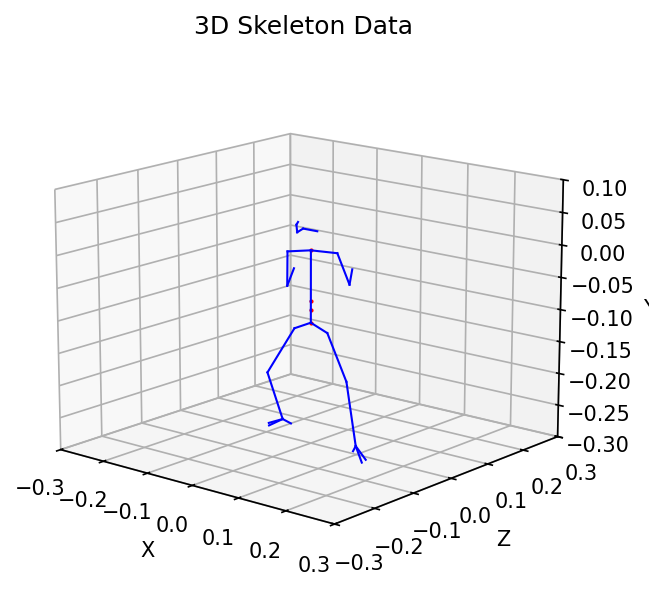

In [752]:
draw_skeleton(reference_poses[550], center=center, normalize=normalize)

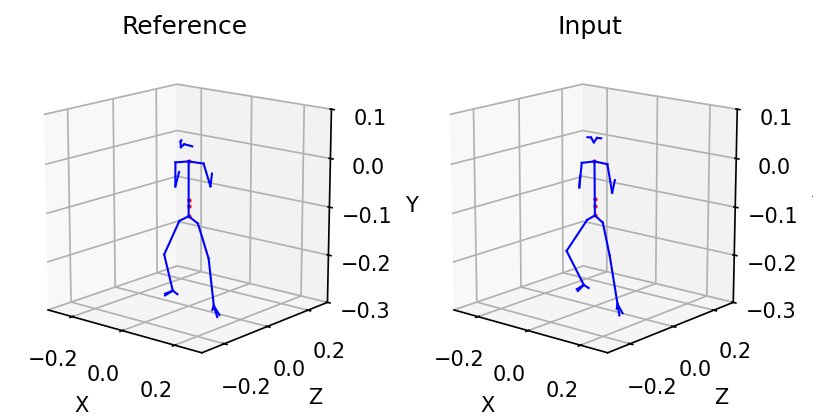

In [758]:
ref_frame = 550
input_frame = 500
draw_skeleton_comparison(reference_poses[ref_frame], input_poses[input_frame], center=center, normalize=normalize)

In [666]:
clip_scorer = PoseSimilarityScorer(skeleton_keypoints=23, coordinates=3)

In [711]:
frame_start = 1400
frame_end = frame_start + 90
input_frames_count = frame_end - frame_start
reference_frames_count = frame_end - frame_start

In [712]:
final_score, score_list = clip_scorer.compare(
    np.asarray(input_poses[frame_start:frame_end]),
    np.asarray(reference_poses[frame_start:frame_end]),
    input_frames_count,
    reference_frames_count,
)
f"Similarity {reference_clip_name} -> {input_clip_name}: {final_score:.2f}%"

'Similarity 20230714_195553 -> 20230714_200057: 71.35%'

Full script

In [22]:
# Load reference poses
reference_poses = load_3d_poses_for_clip(input_path, reference_clip_name, reference_annotation_folder, normalize=True)

# Load poses to compare against the reference
input_poses = load_3d_poses_for_clip(input_path, input_clip_name, input_annotation_folder, normalize=True)

# Compare poses
###############

clip_scorer = PoseSimilarityScorer(skeleton_keypoints=23, coordinates=3)

reference_frames_count = len(reference_poses)
input_frames_count = len(input_poses)

# FOR TESTING PURPOSES (if not using the DWT Fast version)
# reference_frames_count = 300 # about 10s
# input_frames_count = 300

print(f"Comparing poses for {input_frames_count} frames...")
final_score, score_list = clip_scorer.compare(
    np.asarray(input_poses[:input_frames_count]),
    np.asarray(reference_poses[:reference_frames_count]),
    input_frames_count,
    reference_frames_count,
)

scores = {"overall_score": final_score, "scores_list": score_list}

print(f"Similarity *{reference_clip_name}* <-> {input_clip_name}: {final_score:.2f}%")

Comparing poses for 3774 frames...
Similarity *20230714_195553* <-> 20230714_195835: 54.83%
